## Importing modules

In [1]:
import pandas as pd
import numpy as np
import random
from surprise import accuracy
from surprise import Dataset
from surprise import Reader
from surprise import SVD,SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering

from surprise.model_selection import GridSearchCV
from tqdm import tqdm
import matplotlib.pyplot as plt
from surprise.model_selection.validation import cross_validate

## loading datasets

In [2]:
train_df = pd.read_csv(r"C:\Users\pruth\Downloads\project\interactions_train.csv")

test_df = pd.read_csv(r"C:\Users\pruth\Downloads\project\interactions_test.csv")

validation_df = pd.read_csv(r"C:\Users\pruth\Downloads\project\interactions_validation.csv")

recipie = pd.read_csv(r"C:\Users\pruth\Downloads\project\RAW_recipes.csv")

user = pd.read_csv(r"C:\Users\pruth\Downloads\project\RAW_interactions.csv")

{'whiskers': [<matplotlib.lines.Line2D at 0x1d787225550>,
 'caps': [<matplotlib.lines.Line2D at 0x1d787225af0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d787225280>],
 'medians': [<matplotlib.lines.Line2D at 0x1d7872390d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d7872393a0>],
 'means': []}

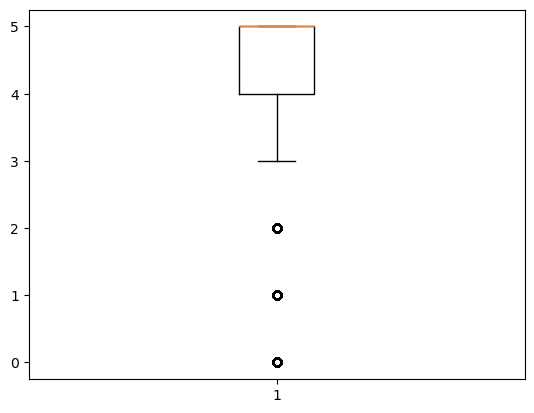

In [4]:
# checking for outliers in ratings 
plt.boxplot(train_df["rating"])


## Building train and test sets

## Reading the data and creating train test splits

In [7]:
test_df

,user_id,recipe_id,date,rating,u,i
0,8937,44551,2005-12-23,4.0,2,173538
1,56680,126118,2006-10-07,4.0,16,177847
2,349752,219596,2008-04-12,0.0,26,89896
3,628951,82783,2007-11-13,2.0,45,172637
4,92816,435013,2013-07-31,3.0,52,177935
...,...,...,...,...,...,...
12450,101053,179011,2009-01-03,5.0,25054,130258
12451,252205,81398,2005-12-26,2.0,25055,152255
12452,624305,142984,2011-01-15,1.0,25057,139864
12453,173575,104842,2004-12-18,3.0,25059,140646


In [8]:
# adding the rating scale of 1 to 10
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train_df[["user_id","recipe_id","rating"]], reader)
raw_ratings = data.raw_ratings

# re arranging the dataset
random.shuffle(raw_ratings)

# splitting the data set into 80:20 training and testing data set
train_test_split_index = int(0.8 * len(raw_ratings))
raw_ratings_train = raw_ratings[:]
raw_ratings_test = raw_ratings[train_test_split_index:]

# constructing the train set
data.raw_ratings = raw_ratings_train  # assign the raw data back

# constructing the test set
testset = data.construct_testset(raw_ratings_test)

## SVDpp model training and Evaluation

In [10]:
"""
SVDpp parameters
N_factors: The number of factors.
N_epochs: The number of iterations of the SGD procedure.
lr_all – The learning rate for all parameters.
reg_all – The regularization term for all parameters.
"""

# constructing different parameter with different range of values
### note: these values are changed in the whole process of training to arrive at this specific values based on rmse scores.
svdpp_params = {
    "n_factors":[1,2], 
    "n_epochs":[10], 
    "lr_all":[0.005], 
    "reg_all":[0.2]
    }

# using grid search cv with above parameters with cross validation of 3 and refit = True
grid_search = GridSearchCV(
    SVDpp,
    param_grid = svdpp_params,
    measures=["rmse"],
    cv=3, 
    refit=True,
    n_jobs=-1,
    joblib_verbose=1
)

# fitting the data 
grid_search.fit(data)

# getting best model out of the grid search and best parameters
best_model = grid_search.best_estimator["rmse"]
print(grid_search.best_params)

# a sample prediction to check the model prediction of a user and book
best_model.predict(uid=51757, iid=112562)

# calculating rmse on test set
testset_predictions = best_model.test(testset)
accuracy.rmse(testset_predictions)

# pickle the model in case the run time stop in between 
import pickle
with open(r"C:\Users\pruth\Downloads\adm\kaggle_best5.pickle", 'wb') as f:
    pickle.dump(best_model, f)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   58.3s remaining:   58.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.0min finished


{'rmse': {'n_factors': 1, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}}
RMSE: 0.8665


In [12]:
accuracy.rmse(testset_predictions)


RMSE: 0.8665


0.8664705733960713